# rule based feature 추출

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from extract_rule_based_features import ExtractFeatures, detect_bead
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from matplotlib import pyplot as plt
from collections import Counter

%matplotlib inline

## Cathode

In [2]:
Cathode_Normal = sorted([x for x in Path("../data/230507/Cathode/Normal").glob("*.csv")])
Cathode_Normal

[PosixPath('../data/230507/Cathode/Normal/20230330_134146_0__02_Total.csv'),
 PosixPath('../data/230507/Cathode/Normal/48.csv'),
 PosixPath('../data/230507/Cathode/Normal/49.csv'),
 PosixPath('../data/230507/Cathode/Normal/50.csv'),
 PosixPath('../data/230507/Cathode/Normal/51.csv'),
 PosixPath('../data/230507/Cathode/Normal/52.csv'),
 PosixPath('../data/230507/Cathode/Normal/53.csv'),
 PosixPath('../data/230507/Cathode/Normal/54.csv'),
 PosixPath('../data/230507/Cathode/Normal/55.csv'),
 PosixPath('../data/230507/Cathode/Normal/56.csv'),
 PosixPath('../data/230507/Cathode/Normal/58.csv'),
 PosixPath('../data/230507/Cathode/Normal/59.csv'),
 PosixPath('../data/230507/Cathode/Normal/61.csv'),
 PosixPath('../data/230507/Cathode/Normal/62.csv'),
 PosixPath('../data/230507/Cathode/Normal/63.csv'),
 PosixPath('../data/230507/Cathode/Normal/64.csv'),
 PosixPath('../data/230507/Cathode/Normal/65.csv'),
 PosixPath('../data/230507/Cathode/Normal/67.csv'),
 PosixPath('../data/230507/Cathode/Norm

In [3]:
len(Cathode_Normal)

31

In [4]:
Cathode_Abnormal = sorted([x for x in Path("../data/230507/Cathode/Abnormal").glob("*.csv")])
Cathode_Abnormal

[PosixPath('../data/230507/Cathode/Abnormal/20230330_134728_0__03_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_134935_0__04_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_135219_0__05_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_135426_0__06_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_140214_0__07_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_140723_0__08_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_140937_0__09_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_141439_0__11_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_141754_0__12_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_142019_0__13_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_142247_0__14_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_142807_0__16_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330

In [5]:
len(Cathode_Abnormal)

17

In [6]:
def check_graph(xs, att=None, piece=1, threshold=None):
    """
    anomaly score and anomaly label visualization

    Parameters
    ----------
    xs : np.ndarray
        anomaly scores
    att : np.ndarray
        anomaly labels
    piece : int
        number of figures to separate
    threshold : float(default=None)
        anomaly threshold

    Return
    ------
    fig : plt.figure
    """
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(12, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = np.arange(L, R)
        if piece == 1:
            ax = axs
        else:
            ax = axs[i]
        ax.plot(xticks, xs[L:R], color='#0C090A')
        ymin, ymax = ax.get_ylim()
        ymin = 0
        ax.set_ylim(ymin, ymax)
        if len(xs[L:R]) > 0 and att is not None:
            ax.vlines(xticks[np.where(att[L:R] == 1)], ymin=ymin, ymax=ymax, color='#FED8B1',
                          alpha=0.6, label='true anomaly')
        ax.plot(xticks, xs[L:R], color='#0C090A', label='anomaly score')
        if threshold is not None:
            ax.axhline(y=threshold, color='r', linestyle='--', alpha=0.8, label=f'threshold:{threshold:.4f}')
        ax.legend()

    return fig

In [7]:
def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
        predict (np.ndarray): the predict label
        actual (np.ndarray): np.ndarray
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    return f1, precision, recall, TP, TN, FP, FN


def adjust_predicts(score, label,
                    threshold=None,
                    pred=None,
                    calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    for i in range(len(score)):
        if actual[i] and predict[i] and not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                for j in range(i, 0, -1):
                    if not actual[j]:
                        break
                    else:
                        if not predict[j]:
                            predict[j] = True
                            latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def PA_percentile(score, label,
                  threshold=None,
                  pred=None,
                  K=100,
                  calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    anomalies = []

    for i in range(len(actual)):
        if actual[i]:
            if not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                anomalies.append([i, i])
            else:
                anomalies[-1][-1] = i
        else:
            anomaly_state = False

    for i, [start, end] in enumerate(anomalies):
        collect = Counter(predict[start:end + 1])[1]
        anomaly_count += collect
        collect_ratio = collect / (end - start + 1)

        if collect_ratio * 100 >= K and collect > 0:
            predict[start:end + 1] = True
            latency += (end - start + 1) - collect

    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def calc_seq(score, label, threshold, K=0, calc_latency=False):
    """
    Calculate f1 score for a score sequence
    """
    if calc_latency:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        #predict, latency = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict, latency = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        t.append(latency)
        return t
    else:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        # predict = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        return t


def bf_search(score, label, start, end=None, step_num=1, display_freq=1, K=0, verbose=True) -> object:
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-f1
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1., -1., -1.)
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target = calc_seq(score, label, threshold, K=K, calc_latency=True)
        if target[0] > m[0]:
            m_t = threshold
            m = target
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    return m, m_t

### Dataset별 bead detection 후 time series concat

In [8]:
def slice_bead_data(path):
    "path: data 저장 경로 (str)"
    extractor = ExtractFeatures(path)
    data = extractor.data
    if 'Abnormal' in path:
        data['label'] = 1
    else:
        data['label'] = 0
        
    bead_array = detect_bead(data['LO'])
    
    total_data = data.iloc[bead_array[0][0]:bead_array[0][1]+1]
    
    for i in range(1, len(bead_array)):
        bead_data = data.iloc[bead_array[i][0]:bead_array[i][1]]
        total_data = pd.concat([total_data, bead_data])
    
    return total_data

## Train Test split
### Train -> 31개 정상 dataset 중 80%인 25개
### Test -> 17개 비정상 dataset + 정상 6개 dataset = 23개 dataset

In [10]:
data_folder_list = Cathode_Normal + Cathode_Abnormal
num_train_dataset = 25
Cathode_Train = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label'])
Cathode_Test = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label'])
for i in range(num_train_dataset):
    bead_i = slice_bead_data(str(data_folder_list[i]))
    Cathode_Train = pd.concat([Cathode_Train, bead_i])

for i in range(num_train_dataset, len(data_folder_list)):
    bead_i = slice_bead_data(str(data_folder_list[i]))
    Cathode_Test = pd.concat([Cathode_Test, bead_i])

warning index: 59479
error index: 59578
warning index: 60128
error index: 60227
warning index: 60777
error index: 60876
warning index: 61427
error index: 61526
warning index: 62076
error index: 62175
warning index: 62725
error index: 62824
warning index: 63374
error index: 63473
warning index: 64022
error index: 64121
warning index: 64671
error index: 64770
warning index: 65321
error index: 65420
warning index: 65970
error index: 66069
warning index: 66619
error index: 66718
warning index: 67268
error index: 67367
warning index: 67917
error index: 68016
warning index: 68567
error index: 68666
warning index: 69216
error index: 69315
warning index: 69865
error index: 69964
warning index: 70514
error index: 70613
warning index: 71163
error index: 71262
warning index: 71813
error index: 71912
warning index: 72462
error index: 72561
warning index: 73111
error index: 73210
warning index: 73760
error index: 73859
warning index: 74409
error index: 74508
warning index: 75058
error index: 75157


In [11]:
Cathode_Train = Cathode_Train.astype(float)
Cathode_Test = Cathode_Test.astype(float)

In [12]:
Cathode_Train_y = Cathode_Train['label']
Cathode_Train_X = Cathode_Train.drop('label', axis=1)
Cathode_Test_y = Cathode_Test['label']
Cathode_Test_X = Cathode_Test.drop('label', axis=1)

### Isolation Forest

In [13]:
IF_clf=IsolationForest(random_state=72).fit(Cathode_Train_X)
IF_pred = IF_clf.predict(Cathode_Test_X)
IF_pred = np.where(IF_pred==1, 0, 1)

In [14]:
tn, fp, fn, tp = confusion_matrix(Cathode_Test_y, IF_pred).ravel()
(tn, fp, fn, tp)

(28628, 3800, 61898, 30913)

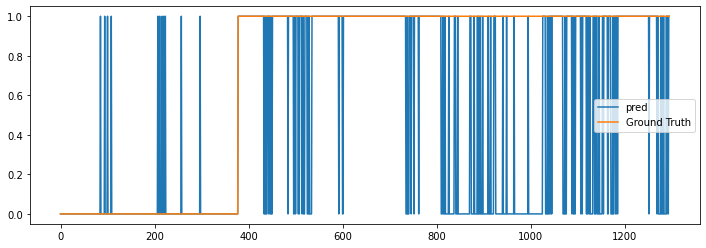

In [18]:
fig = plt.figure(figsize=(12, 4))
plt.plot(IF_pred, label='pred')
plt.plot(np.array(Cathode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

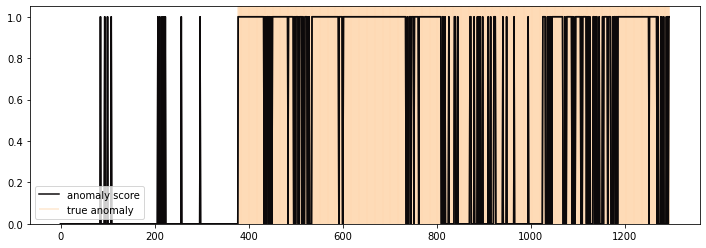

In [19]:
check_graph(IF_pred, np.array(Cathode_Test_y))
plt.show()

In [20]:
IF_anomaly_score = IF_clf.score_samples(Cathode_Test_X)

In [21]:
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-IF_anomaly_score, 
                                                                  np.array(Cathode_Test_y), 
                                                                  start=min(-IF_anomaly_score), 
                                                                  end=max(-IF_anomaly_score), 
                                                                  step_num=1000, 
                                                                  K=100, 
                                                                  verbose=False)
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

AUROC: 0.9436, F1: 0.9219, Precision: 0.9116, Recall: 0.9325


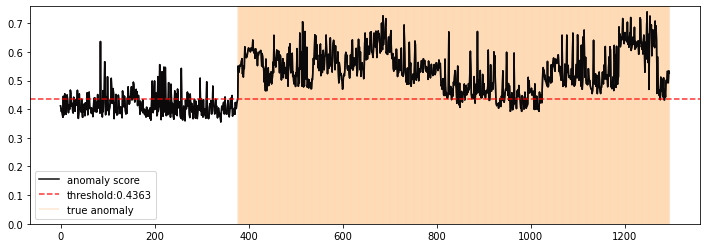

In [22]:
check_graph(-IF_anomaly_score, np.array(Cathode_Test_y), threshold=threshold)
plt.show()

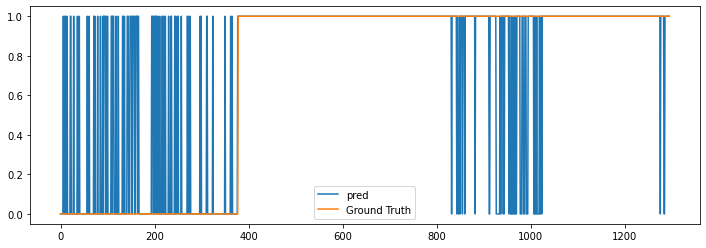

In [23]:
IF_pred = -IF_anomaly_score >= threshold
fig = plt.figure(figsize=(12, 4))
plt.plot(IF_pred, label='pred')
plt.plot(np.array(Cathode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

In [24]:
bead_counter = []
for i in range(len(IF_pred)//54):
    bead_counter.append(dict(Counter(IF_pred[i*54: (i+1)*54])))
print(bead_counter)

[{False: 45, True: 9}, {False: 41, True: 13}, {True: 23, False: 31}, {True: 14, False: 40}, {True: 12, False: 42}, {True: 7, False: 47}, {True: 5, False: 49}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 46, False: 8}, {True: 51, False: 3}, {True: 30, False: 24}, {True: 30, False: 24}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 51, False: 3}]


In [43]:
len(bead_counter)

24

### One-class SVM

In [25]:
OCS_clf = OneClassSVM().fit(Cathode_Train_X)
OCS_pred = OCS_clf.predict(Cathode_Test_X)
OCS_pred = np.where(OCS_pred==1, 0, 1)

In [26]:
tn, fp, fn, tp = confusion_matrix(Cathode_Test_y, OCS_pred).ravel()
(tn, fp, fn, tp)

(173, 205, 96, 822)

In [27]:
OCS_anomaly_score = OCS_clf.score_samples(Cathode_Test_X)

In [28]:
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-OCS_anomaly_score, 
                                                                  np.array(Cathode_Test_y), 
                                                                  start=min(-OCS_anomaly_score), 
                                                                  end=max(-OCS_anomaly_score), 
                                                                  step_num=1000, 
                                                                  K=100, 
                                                                  verbose=False)
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

AUROC: 0.8647, F1: 0.8639, Precision: 0.8893, Recall: 0.8399


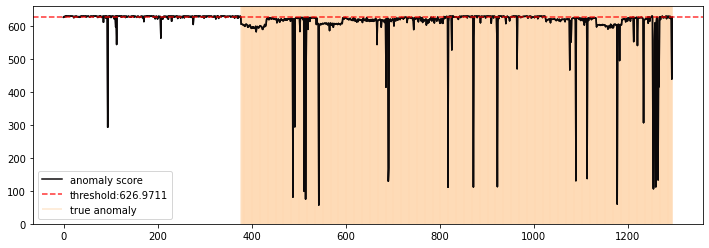

In [29]:
check_graph(OCS_anomaly_score, np.array(Cathode_Test_y), threshold=-threshold)
plt.show()

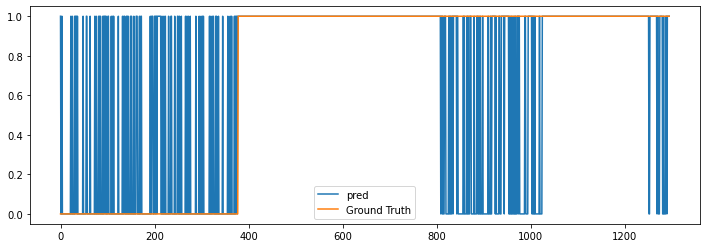

In [30]:
OCS_pred = OCS_anomaly_score <= -threshold
fig = plt.figure(figsize=(12, 4))
plt.plot(OCS_pred, label='pred')
plt.plot(np.array(Cathode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

In [31]:
bead_counter = []
for i in range(len(OCS_pred)//54):
    bead_counter.append(dict(Counter(OCS_pred[i*54: (i+1)*54])))
print(bead_counter)

[{True: 10, False: 44}, {False: 39, True: 15}, {True: 14, False: 40}, {True: 21, False: 33}, {True: 13, False: 41}, {False: 45, True: 9}, {True: 14, False: 40}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 53, False: 1}, {True: 22, False: 32}, {False: 41, True: 13}, {True: 29, False: 25}, {True: 19, False: 35}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 41, False: 13}]


### MoG

In [32]:
# Define the number of mixture components (Gaussian distributions)
n_components = 2

# Create a Gaussian Mixture Model
gmm = GaussianMixture(n_components=n_components, random_state=72).fit(Cathode_Train_X)

In [33]:
# Predict cluster labels for each data point
cluster_labels = gmm.predict(Cathode_Test_X)

# Predict probabilities of each data point belonging to each cluster
cluster_probs = gmm.predict_proba(Cathode_Test_X)

AUROC: 0.9868, F1: 0.0406, Precision: 1.0000, Recall: 0.0207


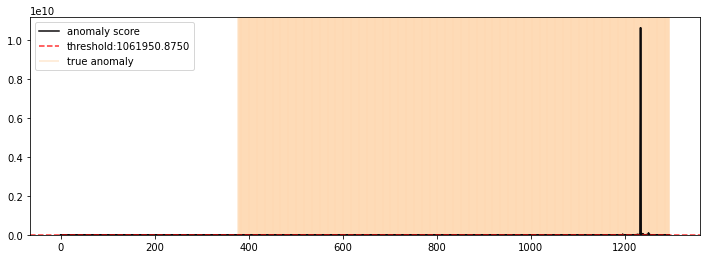

In [35]:
MoG_anomaly_score = gmm.score_samples(Cathode_Test_X)

(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-MoG_anomaly_score, 
                                                                  np.array(Cathode_Test_y), 
                                                                  start=min(-MoG_anomaly_score), 
                                                                  end=max(-MoG_anomaly_score), 
                                                                  step_num=10000, 
                                                                  K=100, 
                                                                  verbose=False)
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
check_graph(-MoG_anomaly_score, np.array(Cathode_Test_y), threshold=threshold)
plt.show()

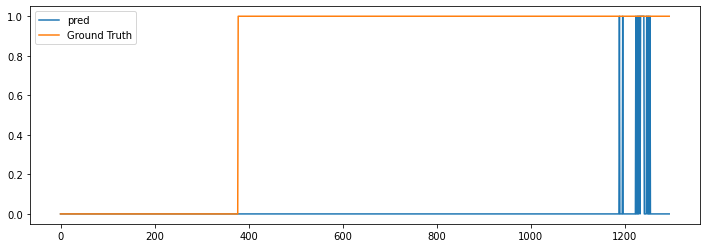

In [36]:
MoG_pred = -MoG_anomaly_score >= threshold
fig = plt.figure(figsize=(12, 4))
plt.plot(MoG_pred, label='pred')
plt.plot(np.array(Cathode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

In [37]:
bead_counter = []
for i in range(len(MoG_pred)//54):
    bead_counter.append(dict(Counter(MoG_pred[i*54: (i+1)*54])))
print(bead_counter)

[{False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 39, True: 15}, {False: 50, True: 4}]


### Parzen windows

In [38]:
bandwidth = 1.0
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(Cathode_Train_X)

AUROC: 0.8776, F1: 0.7605, Precision: 0.9601, Recall: 0.6296


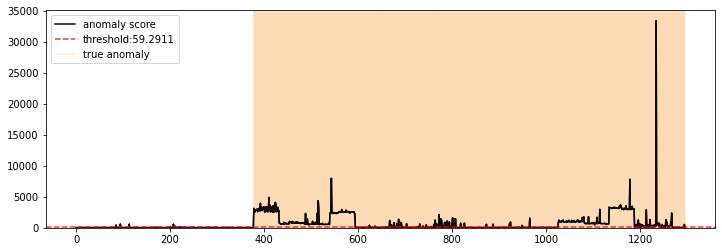

In [40]:
# Estimate the density at each value in the range
# density = np.exp(kde.score_samples(Anode_Test_X))
density = kde.score_samples(Cathode_Test_X)
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-density, 
                                                                  np.array(Cathode_Test_y), 
                                                                  start=min(-density), 
                                                                  end=max(-density), 
                                                                  step_num=1000, 
                                                                  K=100, 
                                                                  verbose=False)
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
check_graph(-density, np.array(Cathode_Test_y), threshold=threshold)
plt.show()

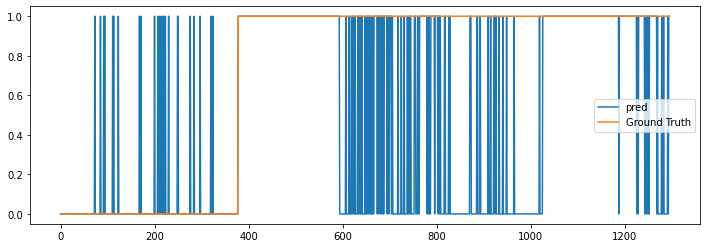

In [41]:
PW_pred = -density >= threshold
fig = plt.figure(figsize=(12, 4))
plt.plot(PW_pred, label='pred')
plt.plot(np.array(Cathode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

In [42]:
bead_counter = []
for i in range(len(PW_pred)//54):
    bead_counter.append(dict(Counter(PW_pred[i*54: (i+1)*54])))
print(bead_counter)

[{False: 54}, {False: 50, True: 4}, {False: 51, True: 3}, {False: 48, True: 6}, {True: 6, False: 48}, {False: 50, True: 4}, {True: 1, False: 53}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {False: 42, True: 12}, {True: 36, False: 18}, {True: 13, False: 41}, {False: 15, True: 39}, {False: 50, True: 4}, {False: 46, True: 8}, {False: 46, True: 8}, {False: 53, True: 1}, {True: 54}, {True: 54}, {True: 54}, {False: 3, True: 51}, {True: 28, False: 26}]


---